### **Pix2Pix**

**Importing Libraries**

In [49]:
import tensorflow as tf
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
from IPython import display
import os
import pandas as pd
import glob
import imageio.v2 as imageio

**Encoder (downsampler) and Decoder (upsampler)**

In [ ]:
def downsample(filters, kernel_size, use_bn=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding="same",
                             kernel_initializer=initializer, use_bias=False)
  ])

  if use_bn:
    model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.LeakyReLU(0.3))

  return model


def upsample(filters, kernel_size, use_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding="same",
                                      kernel_initializer=initializer, use_bias=False)
  ])

  model.add(tf.keras.layers.BatchNormalization())

  if use_dropout:
    model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.ReLU())

  return model

**Models**

In [2]:
# Parameters
epochs = 10
img_channels =3
mask_channels = 3
images_size = 256
batch_size = 16
buffer_size = 128

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def Generator():
  input = tf.keras.layers.Input(shape=(images_size, images_size, img_channels))

  down_stack = [
    downsample(64, 4, use_bn=False),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4) #bottleneck (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, use_dropout=True),
    upsample(512, 4, use_dropout=True),
    upsample(512, 4, use_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last_layer = tf.keras.layers.Conv2DTranspose(mask_channels, 4, strides=2, padding="same",
                                               kernel_initializer=initializer, activation="tanh")

  x = input

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate(axis=-1)([x, skip])

  x = last_layer(x)

  return tf.keras.Model(inputs=input, outputs=x, name="generator")

In [ ]:
generator = Generator()

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                          

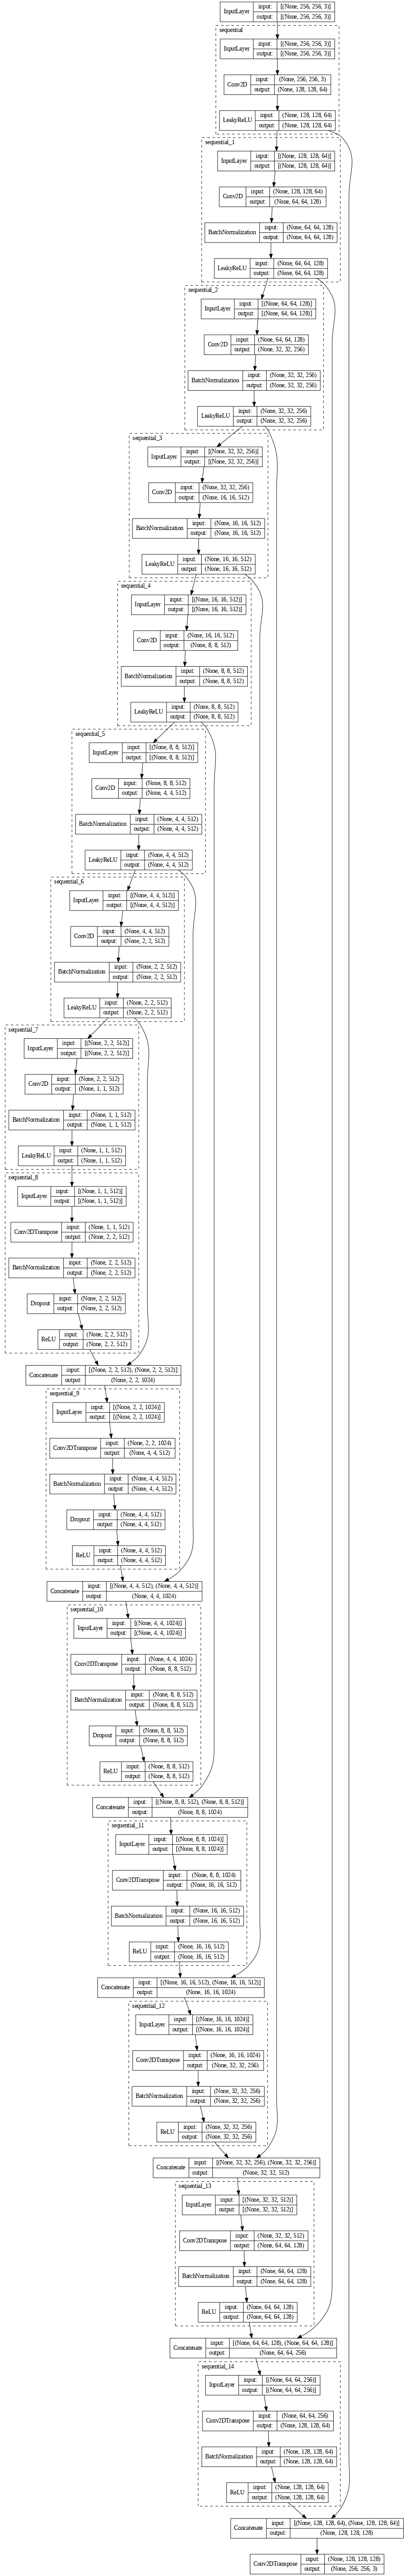

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=False, expand_nested=True, dpi=70)

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  input_images = tf.keras.layers.Input(shape=(images_size, images_size, img_channels), name="input_images")
  input_masks = tf.keras.layers.Input(shape=(images_size, images_size, mask_channels), name="input_masks")

  x = tf.keras.layers.Concatenate(axis=-1)([input_images, input_masks])

  x = downsample(64, 4, use_bn=False)(x)
  x = downsample(128, 4)(x)
  x = downsample(256, 4)(x)

  x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
  x = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.LeakyReLU(0.3)(x)

  x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
  x = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

  return tf.keras.Model(inputs=[input_images, input_masks], outputs=x, name="discriminator")

In [ ]:
discriminator = Discriminator()

discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_images (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_masks (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 256, 256, 6)          0         ['input_images[0][0]',        
 )                                                                   'input_masks[0][0]']         
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate_7[0]

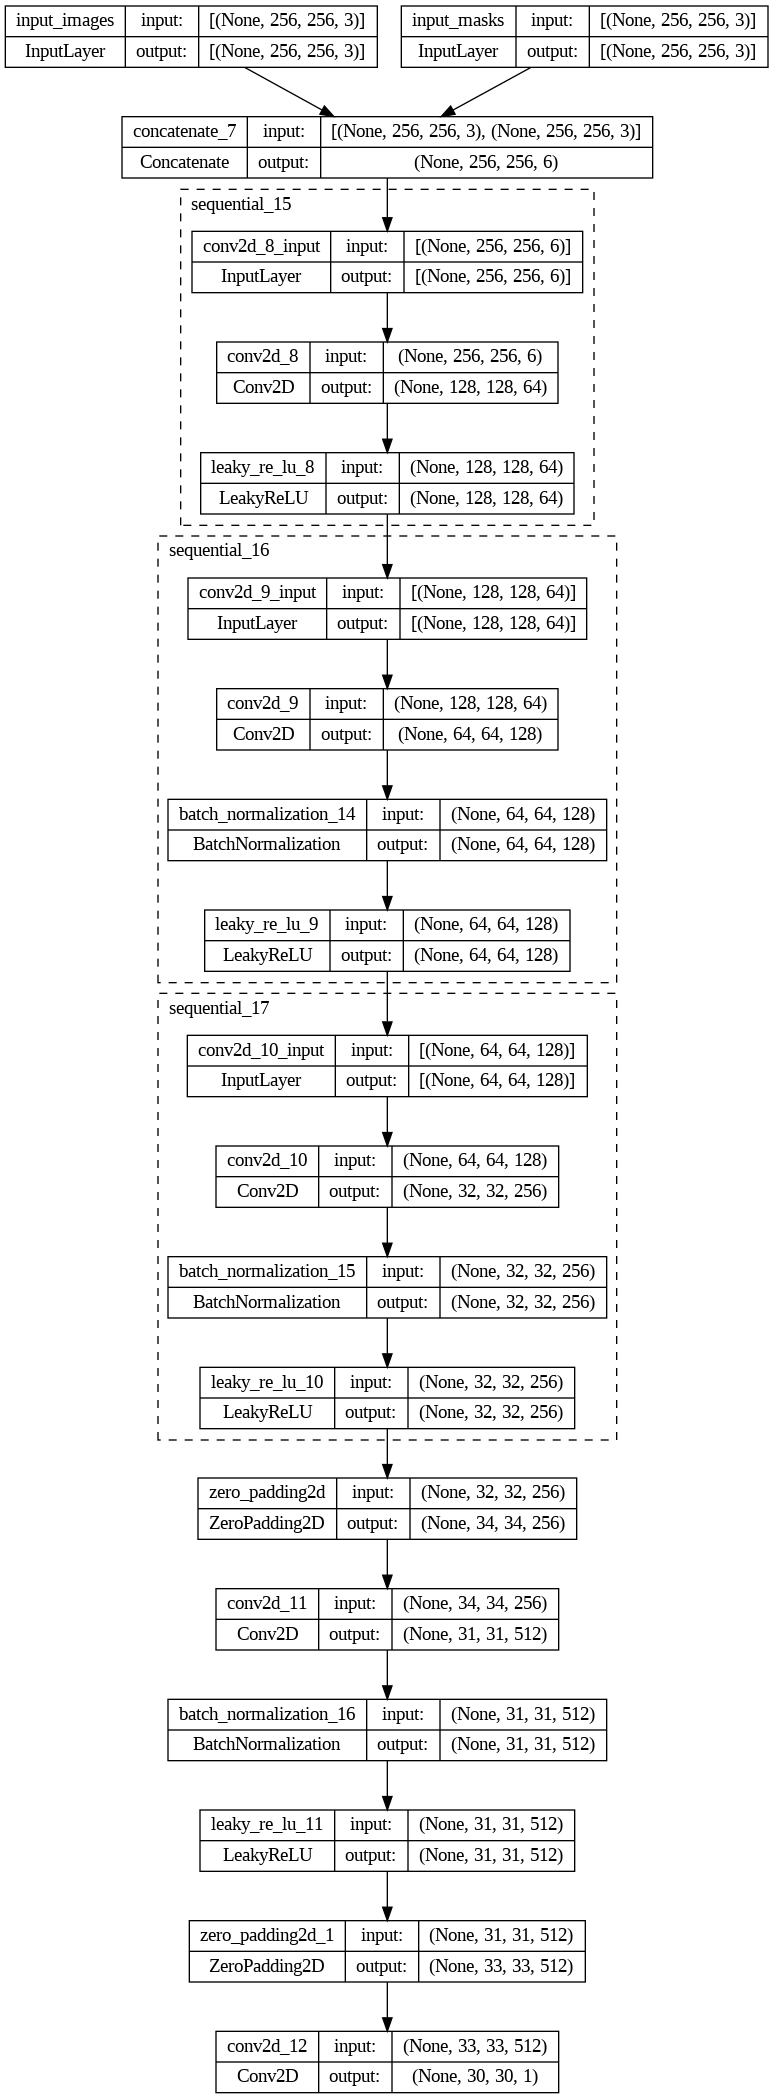

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True, expand_nested=True)

**[Dataset](https://drive.google.com/drive/folders/19giwoxuUnRg0-5cB9SJS7ETY9fmuBOgd?usp=drive_link)**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


(600, 1200, 3)


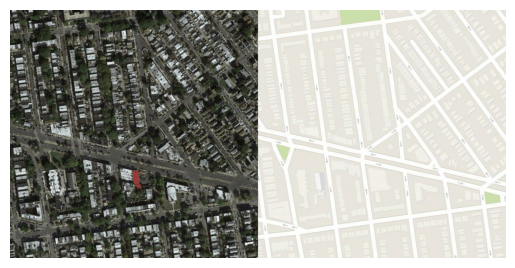

In [6]:
# See the original size of the images.
image = tf.io.read_file("/content/drive/MyDrive/maps/train/1.jpg")
image = tf.image.decode_jpeg(image, channels=3)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

In [3]:
def preprocess_data(images):
  image_width = tf.shape(images)[1]
  imgs = images[:, :image_width // 2]
  imgs = tf.image.resize(imgs, size=(images_size, images_size))
  imgs = (imgs/127.5) - 1
  masks = images[:, image_width // 2:]
  masks = tf.image.resize(masks, size=(images_size, images_size))
  masks = (masks/127.5) - 1

  return imgs, masks

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/drive/MyDrive/maps/",
    labels = None,
    color_mode = "rgb",
    batch_size = None,
    image_size = (600, 1200), #Original shape
    shuffle = False
)

train_dataset = (train_dataset.
                 map(preprocess_data).
                 shuffle(buffer_size, seed=123).
                 batch(batch_size).
                 prefetch(tf.data.AUTOTUNE))

Found 2198 files belonging to 1 classes.


In [5]:
for imgs, masks in train_dataset.take(1):
  print(imgs.shape, masks.shape)

(16, 256, 256, 3) (16, 256, 256, 3)


In [6]:
imgs.numpy().min(), imgs.numpy().max(), masks.numpy().min(), masks.numpy().max()

(-1.0, 1.0, -0.98382354, 1.0)

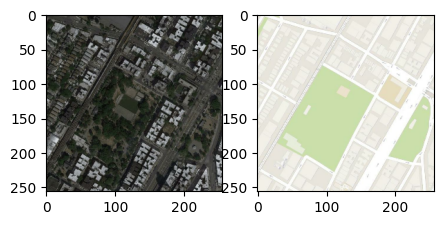

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(5, 5))
ax[0].imshow(tf.cast((imgs[0]+1) * 127.5, tf.uint8))
ax[1].imshow(tf.cast((masks[0]+1) * 127.5, tf.uint8))
plt.show()

**Pix2Pix Training**

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
reconstruct_loss = tf.keras.losses.MeanAbsoluteError() #Equivalent to L1Loss()
lambda_reconstruct = 100

Because the training is lengthy, it's necessary to use checkpoints.

In [ ]:
checkpoint_folder = "/content/drive/MyDrive/checkpoints/TensorFlow_Pix2Pix/"
checkpoint_prefix = os.path.join(checkpoint_folder, "ckpt")

checkpoint = tf.train.Checkpoint(generator = generator,
                                 gen_optimizer = gen_optimizer,
                                 discriminator = discriminator,
                                 disc_optimizer = disc_optimizer)

pretrained = True #Change according to previous training

if pretrained:
  last_epoch = 40 #Put the last epoch of the pretrained model
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))

  history = pd.read_csv(os.path.join(checkpoint_folder, f"losses_epoch_{last_epoch}.csv"))
  history = history.to_dict(orient="list")

else:
  last_epoch = 0
  os.makedirs(checkpoint_folder, exist_ok=True)
  history = {"gen_loss":[], "disc_loss":[]}

In [14]:
# Function to display images

def show_images(images, masks, masks_pred, num_examples, random=True, image_path=None, names=["", ""]):

  # Denormalization
  images = tf.cast((images + 1) * 127.5, tf.uint8)
  masks = tf.cast((masks + 1) * 127.5, tf.uint8)
  masks_pred = tf.cast((masks_pred + 1) * 127.5, tf.uint8)

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  if num_examples == 1:
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].imshow(images[indices[0]])
    ax[0].axis("off")
    ax[0].set_title(names[0], fontsize=10)
    ax[1].imshow(masks[indices[0]])
    ax[1].axis("off")
    ax[1].set_title(f"Real {names[1]}", fontsize=10)
    ax[2].imshow(masks_pred[indices[0]])
    ax[2].axis("off")
    ax[2].set_title(f"Generated {names[1]}", fontsize=10)

  else:
    fig, ax = plt.subplots(num_examples, 3, figsize=(12, 5*num_examples))
    for i in range(num_examples):
      ax[i, 0].imshow(images[indices[i]])
      ax[i, 0].axis("off")
      ax[i, 1].imshow(masks[indices[i]])
      ax[i, 1].axis("off")
      ax[i, 2].imshow(masks_pred[indices[i]])
      ax[i, 2].axis("off")
    ax[0, 0].set_title(names[0], fontsize=10)
    ax[0, 1].set_title(f"Real {names[1]}", fontsize=10)
    ax[0, 2].set_title(f"Generated {names[1]}", fontsize=10)

  if image_path is not None:
    plt.savefig(image_path)
  plt.show()

In [ ]:
@tf.function
def train_step(images, masks):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_masks = generator(images, training=True)

    real_out = discriminator([images, masks], training=True)
    fake_out = discriminator([images, fake_masks], training=True)

    # Generator Loss
    fake_loss_adv = adversarial_loss(tf.ones_like(fake_out), fake_out)
    fake_loss_recon = reconstruct_loss(masks, fake_masks)
    gen_loss = fake_loss_adv + lambda_reconstruct * fake_loss_recon

    # Discriminator Loss
    real_loss = adversarial_loss(tf.ones_like(real_out), real_out)
    fake_loss = adversarial_loss(tf.zeros_like(fake_out), fake_out)
    disc_loss = fake_loss + real_loss

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
def train_model(epochs=epochs, history=history, num_examples=2, save_model=True, display_wait=False):

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []
    current_epoch = last_epoch + epoch +1

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {current_epoch}/{last_epoch + epochs}]")
      for images, masks in pbar:
        gen_loss, disc_loss = train_step(images, masks)

        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())
        pbar.set_postfix({"gen_loss" : gen_loss.numpy(), "disc_loss" : disc_loss.numpy()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=display_wait)
    print(f"Epoch {current_epoch}, Generator (U-Net) Loss: {gen_loss_mean}, Discriminator Loss: {disc_loss_mean}")
    fake_masks = generator(images, training=False)
    show_images(images, masks, fake_masks, num_examples=num_examples, names=["Images", "Masks"])

    if save_model and (current_epoch % 10 == 0):
      checkpoint.save(file_prefix=checkpoint_prefix)

      df = pd.DataFrame(history)
      df.to_csv(os.path.join(checkpoint_folder, f"losses_epoch_{current_epoch}.csv"), index=False)

  return history

Epoch 50, Generator (U-Net) Loss: 8.569707870483398, Discriminator Loss: 0.5554205775260925


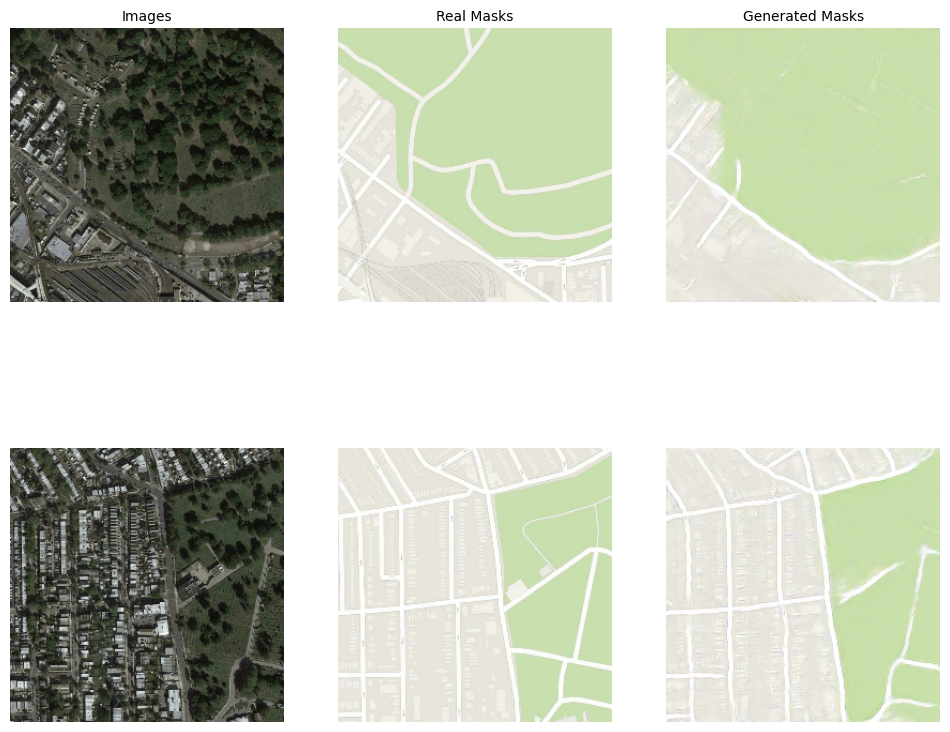

In [ ]:
tf.random.set_seed(123)

history = train_model()

In [ ]:
def plot_metrics(history, renderer=None, epochs = last_epoch + epochs + 1):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(history)

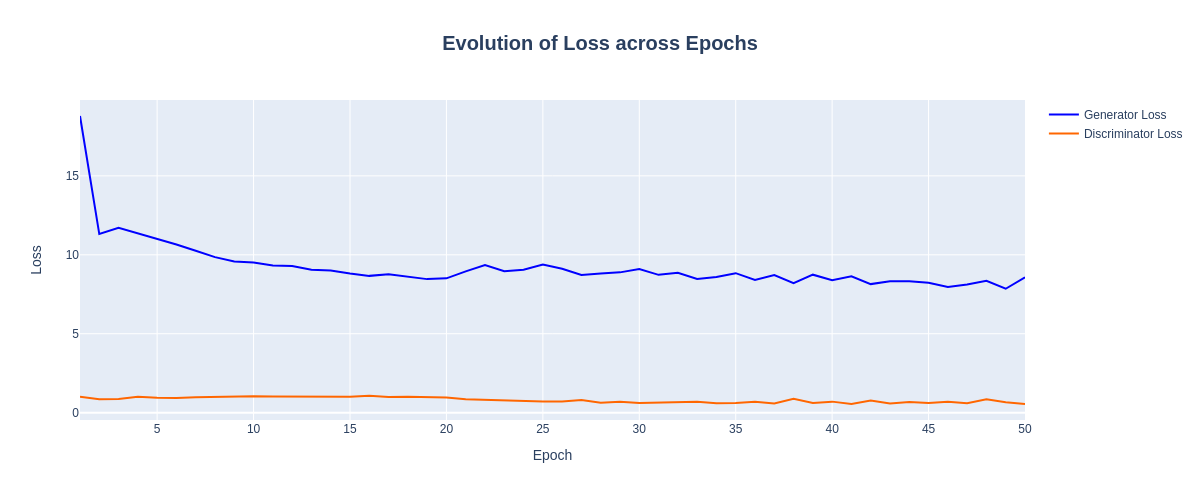

In [ ]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [ ]:
# Save only the generator
generator.save("/content/drive/MyDrive/models/generator_satellite_to_routes.keras")

**Examples with the dataset**

In [8]:
tf.keras.backend.clear_session()

In [9]:
# Load generator
generator = tf.keras.models.load_model("/content/drive/MyDrive/models/generator_satellite_to_routes.keras")

generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                          

In [36]:
# Generating only 5 batches for predictions

images, masks, = [], []

for im, ma in train_dataset.take(6):
  images.append(im)
  masks.append(ma)

images = np.concatenate(images, axis=0)
masks = np.concatenate(masks, axis=0)

images.shape, masks.shape

((96, 256, 256, 3), (96, 256, 256, 3))

In [37]:
masks_pred = generator.predict(images, batch_size=batch_size)

6/6 [==============================] - 1s 94ms/step


**Save the sample images and create a GIF with them**

In [47]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 4.7 MB/s eta 0:00:00


In [48]:
# Function to create gifs

def create_gif(gif_file, images_file):
  with imageio.get_writer(gif_file, mode="I", loop=0, fps=1) as writer:
    filenames = sorted(glob.glob(f"{images_file}/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [50]:
# Image directories
directory_images = "/content/drive/MyDrive/images"
directory_satellites_to_routes = os.path.join(directory_images, "satellites_to_routes")

os.makedirs(directory_satellites_to_routes, exist_ok=True)

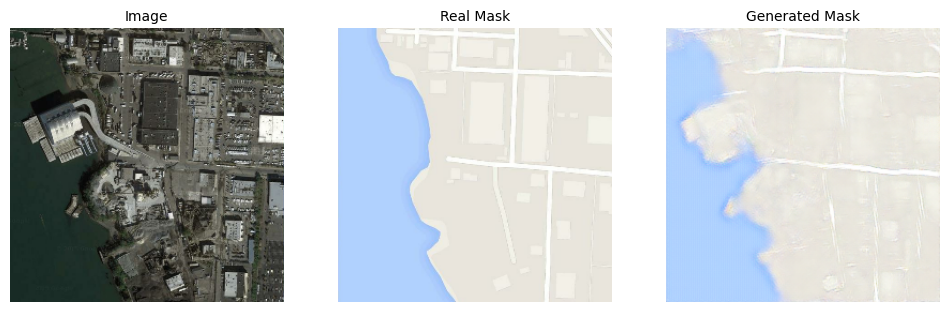

In [51]:
list_indices = [1, 2, 4, 13, 23, 39, 57, 65, 88, 92]

for i, ind in enumerate(list_indices):
  show_images(images[ind][None, :],
              masks[ind][None, :],
              masks_pred[ind][None, :],
              num_examples=1,
              image_path=os.path.join(directory_satellites_to_routes, f"image{i:02d}.png"),
              names=["Image", "Mask"])
  display.clear_output(wait=True)

In [52]:
gif_file = os.path.join(directory_images, "satellites_to_routes.gif")


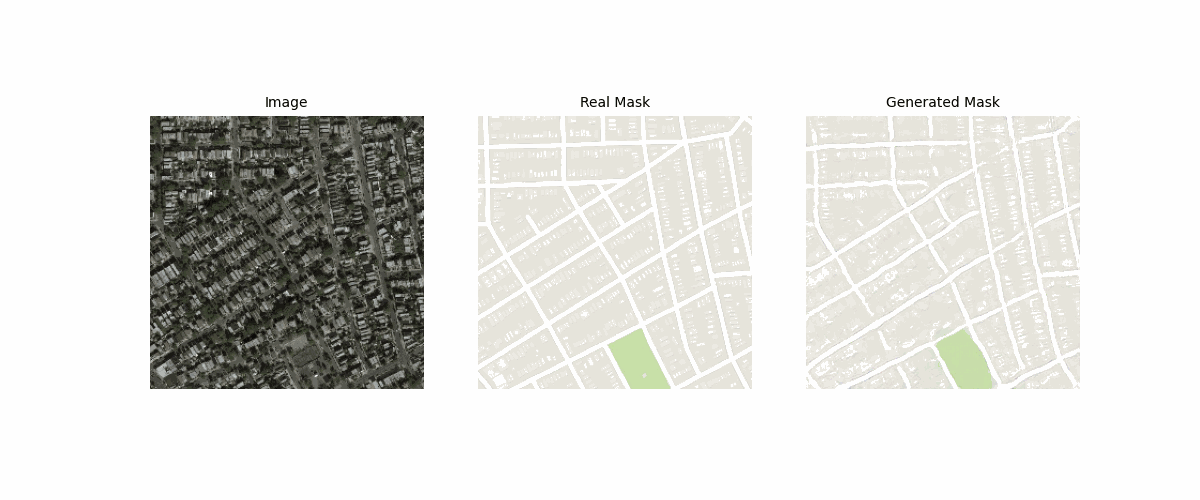

In [53]:
create_gif(gif_file, directory_satellites_to_routes)
embed.embed_file(gif_file)

#### **Code of a model equivalent to Pix2Pix implemented with [PyTorch](Pix2Pix_Satellite2Routes_Pytorch.ipynb)**

**```Model Blocks```**
```
def ContractingBlock(x, channels, use_bn=True, use_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  x = tf.keras.layers.Conv2D(channels*2, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
  if use_bn:
    x = tf.keras.layers.BatchNormalization()(x)
  if use_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  x = tf.keras.layers.Conv2D(channels*2, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
  if use_bn:
    x = tf.keras.layers.BatchNormalization()(x)
  if use_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.LeakyReLU(0.2)(x)

  x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

  return x

def crop(image, new_shape):
  _, height, width, _ = tf.shape(image)
  start_h = (height - new_shape[1]) // 2
  start_w = (width - new_shape[2]) // 2
  cropped_image = image[:, start_h : start_h+new_shape[1], start_w : start_w+new_shape[2]]
  return cropped_image

def ExpandingBlock(x, skip_cont_x, channels, use_bn=True, use_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  x = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")(x)
  x = tf.keras.layers.Conv2D(channels//2, kernel_size=2, padding="same", kernel_initializer=initializer)(x)
  skip_cont_x = crop(skip_cont_x, tf.shape(x))
  x = tf.keras.layers.Concatenate(axis=-1)([x, skip_cont_x])

  x = tf.keras.layers.Conv2D(channels//2, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
  if use_bn:
    x = tf.keras.layers.BatchNormalization()(x)
  if use_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(channels//2, kernel_size=2, padding="same", kernel_initializer=initializer)(x)
  if use_bn:
    x = tf.keras.layers.BatchNormalization()(x)
  if use_dropout:
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.ReLU()(x)

  return x

def FeatureMapBlock(x, channels):
  initializer = tf.random_normal_initializer(0., 0.02)
  return tf.keras.layers.Conv2D(channels, kernel_size=1, kernel_initializer=initializer)(x)
  ```
  **```Models```**
  ```
  def UNet(input_shape, output_channels, hidden_channels=32):

  input = tf.keras.Input(shape=input_shape)
  x0 = FeatureMapBlock(input, hidden_channels)

  x1 = ContractingBlock(x0, hidden_channels, use_dropout=True)
  x2 = ContractingBlock(x1, hidden_channels*2, use_dropout=True)
  x3 = ContractingBlock(x2, hidden_channels*4, use_dropout=True)
  x4 = ContractingBlock(x3, hidden_channels*8)
  x5 = ContractingBlock(x4, hidden_channels*16)
  x6 = ContractingBlock(x5, hidden_channels*32)

  x7 = ExpandingBlock(x6, x5, hidden_channels*64)
  x8 = ExpandingBlock(x7, x4, hidden_channels*32)
  x9 = ExpandingBlock(x8, x3, hidden_channels*16)
  x10 = ExpandingBlock(x9, x2, hidden_channels*8)
  x11 = ExpandingBlock(x10, x1, hidden_channels*4)
  x12 = ExpandingBlock(x11, x0, hidden_channels*2)

  xn = FeatureMapBlock(x12, output_channels)
  xn = tf.keras.layers.Activation("sigmoid")(xn)

  model = tf.keras.Model(inputs=input, outputs=xn, name="generator")

  return model

  def Discriminator(hidden_channels=8):
  initializer = tf.random_normal_initializer(0., 0.02)
  
  input_masks = tf.keras.Input(shape=(images_size, images_size, mask_channels))
  input_images = tf.keras.Input(shape=(images_size, images_size, img_channels))

  x = tf.keras.layers.Concatenate(axis=-1)([input_images, input_masks])
  x = FeatureMapBlock(x, hidden_channels)
  x = ContractingBlock(x, hidden_channels, use_bn=False)
  x = ContractingBlock(x, hidden_channels*2)
  x = ContractingBlock(x, hidden_channels*4)
  x = ContractingBlock(x, hidden_channels*8)
  x = tf.keras.layers.Conv2D(1, kernel_size=1, kernel_initializer=initializer)(x)

  model = tf.keras.Model(inputs=[input_masks, input_images], outputs=x, name="discriminator")

  return model
  ```